## 데이터셋 준비

In [1]:
import pandas as pd

training_sentiment = pd.read_excel('data/training/감성대화말뭉치(최종데이터)_Training.xlsx')
test_sentiment = pd.read_excel('data/validation/감성대화말뭉치(최종데이터)_Validation.xlsx')

# training_sentiment = pd.read_excel('/content/drive/MyDrive/skn/data/training/감성대화말뭉치(최종데이터)_Training.xlsx')
# test_sentiment = pd.read_excel('/content/drive/MyDrive/skn/data/validation/감성대화말뭉치(최종데이터)_Validation.xlsx')

In [2]:
print(training_sentiment['감정_대분류'].unique())
print(test_sentiment['감정_대분류'].unique())

['분노' '기쁨' '불안' '당황' '슬픔' '상처']
['불안' '슬픔' '당황' '기쁨' '분노' '상처']


In [3]:
train_df1 = training_sentiment[['감정_대분류', '사람문장1']].rename(columns={'사람문장1': '문장'})
train_df2 = training_sentiment[['감정_대분류', '사람문장2']].rename(columns={'사람문장2': '문장'})

test_df1 = test_sentiment[['감정_대분류', '사람문장1']].rename(columns={'사람문장1': '문장'})
test_df2 = test_sentiment[['감정_대분류', '사람문장2']].rename(columns={'사람문장2': '문장'})

train_df = pd.concat([train_df1, train_df2], axis=0).reset_index(drop=True)
test_df = pd.concat([test_df1, test_df2], axis=0).reset_index(drop=True)

In [4]:
test_df

,감정_대분류,문장
0,불안,이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어. 너...
1,불안,회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워.
2,불안,상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워.
3,불안,이번에 힘들게 들어간 첫 직장이거든. 첫 직장이라서 그런지 너무 긴장된다.
4,불안,직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼.
...,...,...
13277,당황,우리만 뒤처지는 것 같고. 그래도 열심히 살다 보면 우리도 집을 살 수 있겠지?
13278,당황,나도 결혼했지만 아이도 생기지 않고 그 정도로 행복하지 않거든. 친구보다 못사는 것...
13279,당황,요새 집값이 너무 올라서 한숨만 나와.
13280,당황,맞아. 그 친구와 비교하게 되니 자존감이 낮아지는 기분이야.


In [5]:
# 결측치 전처리
print(train_df.isnull().sum())
print(test_df.isnull().sum())

감정_대분류    0
문장        0
dtype: int64
감정_대분류    0
문장        0
dtype: int64


In [7]:
import re
import torch
import torch.nn.functional as F

# hleper function

def load_stopwords(filepath):
    with open(filepath, 'r', encoding='UTF-8') as f:
        stopwords = [line.strip() for line in f]
    return stopwords

def preprocess(sentence, okt):

    # 숫자, 영문, 특수문자, 이모지, 공백 제거
    sentence = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', '', sentence)

    # 어근 분리 및 토큰화
    tokens = okt.morphs(sentence, stem =True)

    # 불용어 제거
    # ko_stopwords = load_stopwords('/content/drive/MyDrive/skn/data/ko_stopwords.txt')
    ko_stopwords = load_stopwords('data/ko_stopwords.txt')
    # ko_stopwords = ["은", "는", "이", "가", "을", "를", "과", "와", "들", "도",
    #                 "부터", "까지", "에", "나", "너", "그", "걔", "얘"]

    cleaned_tokens = [token for token in tokens if token not in ko_stopwords]

    return cleaned_tokens

def pad_sequences(sequences, maxlen, padding_value=0):
    padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
    return torch.stack(padded_sequences)

In [8]:
from konlpy.tag import Okt
from tqdm import tqdm

okt = Okt()
# 단어사전 (key=단어, value=빈도)
vocab = {}
train_data = []
test_data = []

# 훈련데이터 전처리
for sentence in tqdm(train_df['문장']):
    tokens = preprocess(sentence, okt)

    # 훈련데이터에서 단어사전 생성
    for token in tokens:
        if token not in vocab:
            vocab[token] = 1
        else:
            vocab[token] += 1

    train_data.append(tokens)

# 평가데이터 전처리
for sentence in tqdm(test_df['문장']):
    tokens = preprocess(sentence, okt)
    test_data.append(tokens)

100%|██████████| 13282/13282 [00:17<00:00, 747.97it/s]


In [9]:
vocab_size = 10000
vocab_sorted = sorted(vocab.items(), key=lambda item: item[1], reverse=True)
word_to_idx = {word: i+1 for i, (word, cnt) in enumerate(vocab_sorted)}
word_to_idx = {word: index for word, index in word_to_idx.items() if index <= vocab_size}
word_to_idx['OOV'] = len(word_to_idx) + 1
print(len(vocab), len(word_to_idx))

13435 10001


In [26]:
print(word_to_idx)

{'하다': 1, '내': 2, '너무': 3, '도': 4, '없다': 5, '친구': 6, '는': 7, '보다': 8, '못': 9, '안': 10, '않다': 11, '은': 12, '되다': 13, '좋다': 14, '이야': 15, '싶다': 16, '들다': 17, '만': 18, '사람': 19, '말': 20, '생각': 21, '받다': 22, '게': 23, '돼다': 24, '모르다': 25, '더': 26, '힘들다': 27, '돈': 28, '수': 29, '하고': 30, '자다': 31, '그렇다': 32, '다': 33, '정말': 34, '나다': 35, '걱정': 36, '때문': 37, '고': 38, '한': 39, '나르다': 40, '한테': 41, '많이': 42, '거': 43, '남편': 44, '어떻다': 45, '회사': 46, '가다': 47, '슬프다': 48, '요즘': 49, '부모님': 50, '아내': 51, '적': 52, '아니다': 53, '마음': 54, '해': 55, '이제': 56, '나이': 57, '많다': 58, '아프다': 59, '난': 60, '오늘': 61, '스럽다': 62, '결혼': 63, '집': 64, '엄마': 65, '가족': 66, '먹다': 67, '오다': 68, '자식': 69, '공부': 70, '기분': 71, '인데': 72, '지금': 73, '살다': 74, '되어다': 75, '나오다': 76, '몸': 77, '준비': 78, '직장': 79, '화가': 80, '날': 81, '걸': 82, '일이': 83, '인': 84, '랑': 85, '맞다': 86, '해주다': 87, '자꾸': 88, '주다': 89, '아들': 90, '불안하다': 91, '싫다': 92, '라고': 93, '건강': 94, '아무': 95, '취업': 96, '열심히': 97, '당하다': 98, '속상하다': 99, '다니다': 100, '거야': 101, '

In [10]:
# 수열처리
train_encoded = []
test_encoded = []
oov_idx = word_to_idx['OOV']

# 훈련데이터 수열처리
train_encoded = [[word_to_idx.get(token, oov_idx) for token in sentence] for sentence in tqdm(train_data)]
train_seq = [torch.tensor(seq, dtype=torch.long) for seq in train_encoded]

# 평가데이터 수열처리
test_encoded = [[word_to_idx.get(token, oov_idx) for token in sentence] for sentence in tqdm(test_data)]
test_seq  = [torch.tensor(seq, dtype=torch.long) for seq in test_encoded]


100%|██████████| 13282/13282 [00:00<00:00, 538685.95it/s]


In [27]:
import torch.nn as nn

EMBEDDING_DIM = 100

num_words = len(word_to_idx)+1
SEQ_LEN = max([len(sentence) for sentence in train_encoded])
print(SEQ_LEN)
# 패딩 처리
train_input = pad_sequences(train_seq, maxlen=SEQ_LEN)
test_input = pad_sequences(test_seq, maxlen=SEQ_LEN)

print(train_input)

# 원핫인코딩 처리 -> 딥러닝에서는 원핫인코딩을 사용하지 않음.
                #  TfidfVectorizer나 countvectorizer 같이 전통적인 머신러닝에서 사용되는 모델은
                #  메모리를 효율적으로 사용하기 때문에 가능하지만 원핫은 무지성이라 단어사전 개수가 많으면 사용불가
# train_onehot = F.one_hot(train_input, num_classes=num_words) # 이거때문에 단어사전을 1000개밖에 쓸 수가 없음
# test_onehot = F.one_hot(test_input, num_classes=num_words)

train_input.shape, test_input.shape

47
tensor([[  12,  216,  216,  ...,    0,    0,    0],
        [ 347, 1398, 2128,  ...,    0,    0,    0],
        [  46,  888,  356,  ...,    0,    0,    0],
        ...,
        [ 205,   19,   12,  ...,    0,    0,    0],
        [  56,    1,   29,  ...,    0,    0,    0],
        [  19,  115,  122,  ...,    0,    0,    0]])


(torch.Size([103260, 47]), torch.Size([13282, 47]))

In [12]:
labels_list = train_df['감정_대분류'].unique()
label2idx = {label: i for i, label in enumerate(labels_list)}

train_labels = [label2idx[label] for label in train_df['감정_대분류']]
test_labels  = [label2idx[label] for label in test_df['감정_대분류']]

train_target = torch.tensor(train_labels)
test_target  = torch.tensor(test_labels)
NUM_CLASSES = len(labels_list)

In [13]:
train_df['감정_대분류'].unique()

array(['분노', '기쁨', '불안', '당황', '슬픔', '상처'], dtype=object)

In [14]:
label2idx

{'분노': 0, '기쁨': 1, '불안': 2, '당황': 3, '슬픔': 4, '상처': 5}

In [15]:
# train 데이터와 라벨을 다시 데이터프레임으로 결합
train_check_df = pd.DataFrame({
    '문장': [' '.join(seq) for seq in train_data],  # 토큰 리스트를 문자열로 합침
    '라벨': train_labels
})

# 상위 5개 확인
print(train_check_df[:50])

                                                   문장  라벨
0                                  은 해도 해도 끝 없다 화가 나다   0
1                       달 급여 깎다 물가 는 월급 만 자꾸 깎다 너무 화가   0
2     회사 신입 들어오다 말투 거슬리다 그렇다 애 매일 보다 하다 생각 하다 스트레스 받다   0
3          직장 막내 라는 이유 에게만 온갖 심부름 일도 많다 데 정말 분하다 섭섭하다   0
4                         전 입사 한 신입사원 나르다 무시 하다 너무 화가   0
5                    직장 다니다 만 버리다 거 진지하다 진로 대한 고민 생기다   0
6            성인 인데 도 진로 아직도 못 정 하다 부모님 노 워 하다 나다 섭섭하다   0
7                             퇴사 한 지다 안 돼다 천천히 직장 해보다   1
8           졸업 반 이라서 취업 생각 하다 하다 지금 너무 느긋하다 이래도 되다 싶다   2
9                                  요즘 직장 생활 너무 편하다 좋다   1
10                         취업 하다 하다 나이 인데 취업 하고 싶다 않다   1
11                               면접 부모님 직업 대한 질문 들어오다   2
12     큰일 이야 부장 님 께 결재 받다 하다 서류 사라지다 하다 뒤 제출 하다 하다 가다   2
13  전 면접 보다 회사 면접 합격 하다 연락 받다 오늘 다시 입사 취소 통보 받다 당혹스럽다   2
14         길 가다가 우연히 마주치다 동네 아주머니 께서 취업 하다 물어보다 당황 하다   3
15     어제 합격 통보 받다 회사 문자 잘못 발송 하다 연락 오다 너무 당혹스럽다 속상하다   3
16            

## 모델 정의

In [16]:
import torch.nn as nn

# 간단한 RNN 모델 정의
class SentimentRNN(nn.Module):
    def __init__(self, seq_len, vocab_size, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()
        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, hidden = self.rnn(x)
        out = self.fc(hidden.squeeze(0))
        return out

In [ ]:
HIDDEN_DIM = 8
OUTPUT_DIM = 6

model = SentimentRNN(
    seq_len=SEQ_LEN,
    vocab_size=num_words,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

print(model)

SentimentRNN(
  (rnn): RNN(1002, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=6, bias=True)
  (sigmoid): Sigmoid()
)


In [28]:
import torch.nn as nn

class EBDSentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.3):
        super(EBDSentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

In [30]:
HIDDEN_DIM = 64
OUTPUT_DIM = 6
EMBEDDING_DIM = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ebd_lstm_model = EBDSentimentLSTM(
    vocab_size=num_words,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

ebd_lstm_model = ebd_lstm_model.to(device)
print(ebd_lstm_model)

EBDSentimentLSTM(
  (embedding): Embedding(10002, 128)
  (lstm): LSTM(128, 64, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [22]:
import torch
print(torch.cuda.is_available())
print(device)

False
cpu


## 학습

In [33]:
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

def train_func(train_data, train_label, model, device=device):
    # 학습을 위한 설정
    # 배치 사이즈, 학습/검증셋 크기 설정
    BATCH_SIZE = 65
    train_size = int(len(train_data) * 0.8)
    val_size = len(train_data) - train_size

    # 데이터 학습/검증셋 분할
    train_dataset, val_dataset = random_split(TensorDataset(train_data, train_label), [train_size, val_size])
    # 미니배치로 사용할 수 있도록 DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # epoch(학습 횟수), 손실 함수, 최적화 함수 정의
    epochs = 100
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    # 시각화를 위한 손실값/정확도 저장용 배열 생성
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # 조기종료 관련 변수 초기화
    early_stopping_patience = 7
    best_val_loss = float('inf')
    early_stop_counter = 0

    # 학습 진행
    for epoch in range(epochs):

        # 학습 모드
        model.train()
        total_loss, correct, total = 0, 0, 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()               # 가중치 초기화
            outputs = model(inputs)   # 순전파
            loss = criterion(outputs, targets)  # 손실 계산

            loss.backward()                     # 역전파
            optimizer.step()                    # 가중치 갱신
            total_loss += loss.item()

            pred = outputs.argmax(dim=1)
            correct += (pred == targets).sum().item()
            total += targets.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # 검증 모드
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_targets)
                val_loss += loss.item()

                val_pred = val_outputs.argmax(dim=1)
                val_correct += (val_pred == val_targets).sum().item()
                val_total += val_targets.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        # print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # 조기 종료
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_patience:
                print("Early Stopping 할게~~~~~!")
                break

    # 학습 과정 시각화
    train_history_df = pd.DataFrame({
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    })

    train_history_df.plot()
    plt.show()


def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for val_inputs, val_targets in test_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs).squeeze()
            loss = criterion(val_outputs, val_targets)
            val_loss += loss.item()

            val_pred = val_outputs.argmax(dim=1)
            val_correct += (val_pred == val_targets).sum().item()
            val_total += val_targets.size(0)

    val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total
    return val_loss, val_acc

Epoch 1/100 | Train Loss: 1.4619, Train Acc: 0.4074, Val Loss: 1.3379, Val Acc: 0.4797
Epoch 2/100 | Train Loss: 1.2690, Train Acc: 0.5114, Val Loss: 1.3258, Val Acc: 0.4842
Epoch 3/100 | Train Loss: 1.1815, Train Acc: 0.5525, Val Loss: 1.3414, Val Acc: 0.4880
Epoch 4/100 | Train Loss: 1.0977, Train Acc: 0.5851, Val Loss: 1.3872, Val Acc: 0.4831
Epoch 5/100 | Train Loss: 1.0212, Train Acc: 0.6178, Val Loss: 1.4303, Val Acc: 0.4790
Epoch 6/100 | Train Loss: 0.9492, Train Acc: 0.6503, Val Loss: 1.4854, Val Acc: 0.4714
Epoch 7/100 | Train Loss: 0.8854, Train Acc: 0.6751, Val Loss: 1.5500, Val Acc: 0.4689
Epoch 8/100 | Train Loss: 0.8319, Train Acc: 0.6957, Val Loss: 1.6059, Val Acc: 0.4606
Epoch 9/100 | Train Loss: 0.7844, Train Acc: 0.7166, Val Loss: 1.6701, Val Acc: 0.4633
Early Stopping 할게~~~~~!


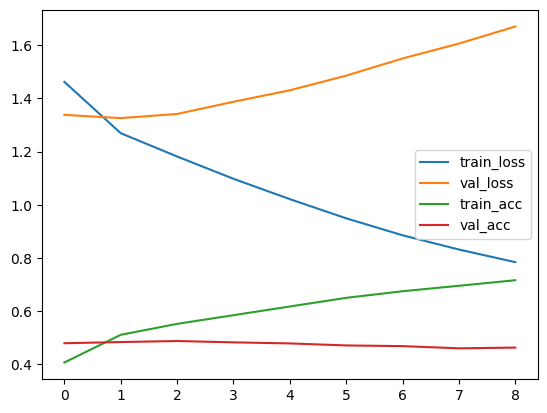

In [32]:
train_func(train_input, train_target, ebd_lstm_model)

## 추론

In [36]:
test_dataset = TensorDataset(test_input, test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

criterion = nn.CrossEntropyLoss()

loss, accuracy = evaluate_model(ebd_lstm_model, test_loader, criterion)
loss, accuracy

(1.3554932938843238, 0.5597801535913266)

In [48]:
def predict_sentiment(model, sentence, word_to_idx, okt, seq_len, device):
    model.eval()
    tokens = preprocess(sentence, okt)
    oov_idx = word_to_idx.get('OOV', 0)
    encoded = [word_to_idx.get(token, oov_idx) for token in tokens]
    sequnce = torch.tensor(encoded, dtype=torch.long).unsqueeze(0)
    input = pad_sequences(sequnce, maxlen=SEQ_LEN)

    with torch.no_grad():
        output = model(input)
        pred = output.argmax(dim=1).item()
    return pred

In [44]:
label2idx

{'분노': 0, '기쁨': 1, '불안': 2, '당황': 3, '슬픔': 4, '상처': 5}

In [49]:
sentence = "오늘 너무 기분이 좋아!"
pred_label = predict_sentiment(ebd_lstm_model, sentence, word_to_idx, okt, SEQ_LEN, device)
print("예측 라벨:", pred_label)

예측 라벨: 1


In [52]:
sentence = input("문장을 입력하세요: ")
print("입력 문장:", sentence)
pred_label = predict_sentiment(ebd_lstm_model, sentence, word_to_idx, okt, SEQ_LEN, device)
print("예측 라벨:", pred_label)

입력 문장: 흑흑흑
예측 라벨: 4


In [51]:
sentence = input("문장을 입력하세요: ")
print("입력 문장:", sentence)
pred_label = predict_sentiment(ebd_lstm_model, sentence, word_to_idx, okt, SEQ_LEN, device)
print("예측 라벨:", pred_label)

입력 문장: 무야호~!
예측 라벨: 1
